# FIFA Overall Rating Predictor

### In this machine learning notebook, we will try to make a model that predicts a player's overall rating by training on various player stats 

In [1]:
import pandas as pd
import sklearn

### Importing the data

In [2]:
fifa_data = pd.read_csv("data.csv")

In [3]:
fifa_data.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


### Creating a test dataset and training dataset

In [4]:
#creates 6 categories based on player's overall score
#category 1 ranges from 0-50, category 2 ranges from 50-60, category 3 ranges from 60-70, etc.

fifa_data["overall_cat"] = pd.cut(fifa_data["Overall"],bins=[0., 50, 60, 70, 80, 90,100],
                               labels=[1, 2, 3,4,5,6])

In [5]:
fifa_data["overall_cat"].value_counts()

3    9905
4    4337
2    3361
5     403
1     192
6       9
Name: overall_cat, dtype: int64

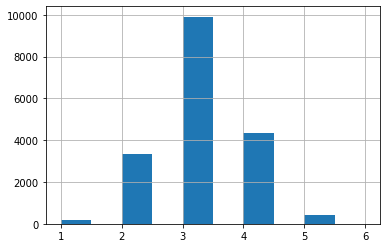

In [6]:
%matplotlib inline
fifa_data["overall_cat"].hist()
#categories are somewhat normally distributed

#### Creating testing and training datasets using stratified sampling based on 6 categories

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

#20% of data will be used for testing
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(fifa_data, fifa_data["overall_cat"]):
    strat_train_set = fifa_data.loc[train_index]
    strat_test_set = fifa_data.loc[test_index]

In [8]:
strat_test_set["overall_cat"].value_counts()/len(strat_test_set)

3    0.543932
4    0.238331
2    0.184514
5    0.022241
1    0.010434
6    0.000549
Name: overall_cat, dtype: float64

In [9]:
strat_train_set["overall_cat"].value_counts()/len(strat_train_set)

3    0.544044
4    0.238174
2    0.184621
5    0.022108
1    0.010573
6    0.000481
Name: overall_cat, dtype: float64

As desired, proportions of overall scores are very close between test and training datasets

In [10]:
#restoring the dataset by removing overall_cat
for set_ in (strat_train_set, strat_test_set):
    set_.drop("overall_cat", axis=1, inplace=True)

In [11]:
fifa_data = strat_train_set.copy()

### Interpreting and Visualizing the Data

In [12]:
# correlations with respect to Overall score
correlations = fifa_data.corr()
correlations["Overall"].sort_values(ascending=False)

Overall                     1.000000
Reactions                   0.850435
Composure                   0.728367
Potential                   0.663949
Special                     0.605502
Vision                      0.502869
ShortPassing                0.499474
International Reputation    0.496111
LongPassing                 0.482318
BallControl                 0.458097
Age                         0.450889
ShotPower                   0.439060
LongShots                   0.422281
Curve                       0.418127
Skill Moves                 0.416248
FKAccuracy                  0.396479
Crossing                    0.392279
Aggression                  0.391098
Volleys                     0.387416
Dribbling                   0.372536
Stamina                     0.361966
Positioning                 0.355491
Strength                    0.346342
Penalties                   0.339326
HeadingAccuracy             0.331776
Finishing                   0.330864
Interceptions               0.316153
M

We have some strong correlations!  Let's pick a few features: Reactions, Composure, International Reputation, Age, and Skill Moves

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa24f1e390>,
      dtype=object)

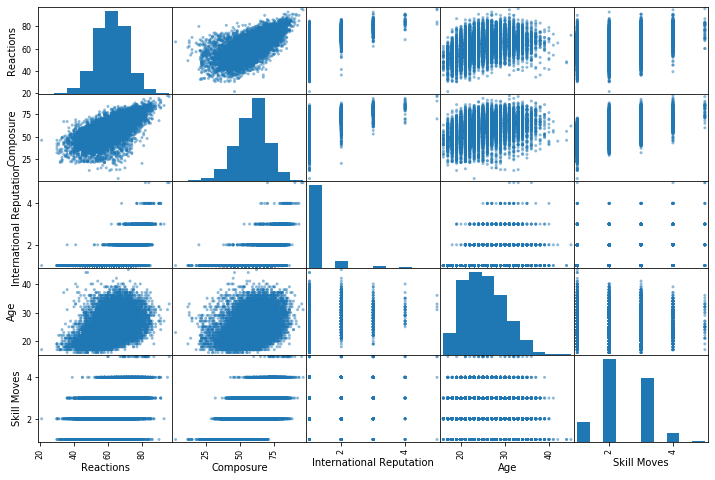

In [13]:
from pandas.plotting import scatter_matrix

attributes = ["Reactions", "Composure", "International Reputation", "Age", "Skill Moves"]
scatter_matrix(fifa_data[attributes], figsize=(12, 8))

### Preparing Data

In [14]:
fifa_data = strat_train_set.drop("Overall", axis=1)
fifa_labels = strat_train_set["Overall"].copy()

Transformation Pipeline

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#fills in missing values and scales features appropriately
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

fifa_data_final = num_pipeline.fit_transform(fifa_data[attributes])

In [16]:
fifa_data_final

array([[-0.20024466, -0.75667796, -0.28594586,  1.05665331, -1.80027037],
       [ 2.12874735,  0.73463991, -0.28594586,  0.19518365, -0.47577989],
       [-0.64386218, -0.84440254, -0.28594586,  0.8412859 , -0.47577989],
       ...,
       [-0.97657533,  0.47146617, -0.28594586,  0.41055107,  0.84871058],
       [-0.08934028,  0.99781365, -0.28594586,  2.3488578 , -0.47577989],
       [ 0.13246849, -1.0198517 , -0.28594586,  0.19518365, -1.80027037]])

### Training Models

Let's try a linear regression model first

In [17]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(fifa_data_final, fifa_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error

#and let's see the amount of error
fifa_predictions = lin_reg.predict(fifa_data_final)
lin_mse = mean_squared_error(fifa_labels, fifa_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3.2628446112976937

On average, this model is off by about 3.26 points.  Not bad, but let's test some other models

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(fifa_data_final, fifa_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [20]:
fifa_predictions = tree_reg.predict(fifa_data_final)
tree_mse = mean_squared_error(fifa_labels, fifa_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1.3163068316888742

The decision tree model did REALLY well.  It might even be overfitting the data.  To see this let's test our model using cross-validation.  This will give us better insights to how our model is actually performing

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, fifa_data_final, fifa_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [22]:
def display_scores(scores):
    print("scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

scores: [3.998335   4.03759149 3.94367144 3.91919101 3.89034855 3.92867956
 4.00327092 4.05385711 4.0959413  3.90577755]
Mean: 3.9776663918350463
Standard deviation: 0.06650934469612514


This tells us that the decision tree isn't so great after all.  Let's see if linear regression is indeed better

In [23]:
lin_scores = cross_val_score(lin_reg, fifa_data_final, fifa_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

scores: [3.21734903 3.20806716 3.27023733 3.21078123 3.18638949 3.26870589
 3.2736456  3.37678636 3.40395313 3.21755255]
Mean: 3.263346778192105
Standard deviation: 0.06983928035610247


We can see that the decision tree model actually does worse than linear regression when tested by cross-validation. Let's try one last model and test it using cross-validation

In [24]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(fifa_data_final, fifa_labels)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [25]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, fifa_data_final, fifa_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

scores: [3.15148778 3.21695077 3.20099885 3.16825767 3.15674069 3.24235425
 3.14389396 3.25281255 3.30574687 3.22923731]
Mean: 3.206848070130526
Standard deviation: 0.04981957473357729


This model did slightly better than the linear regression model!  Let's go ahead and fine tune it

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4, 5]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(fifa_data_final, fifa_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 3, 4, 5],
  

In [27]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [28]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [29]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

3.4721986927795827 {'max_features': 2, 'n_estimators': 3}
3.250436252922805 {'max_features': 2, 'n_estimators': 10}
3.1806171525023537 {'max_features': 2, 'n_estimators': 30}
3.472826105288583 {'max_features': 3, 'n_estimators': 3}
3.266188368624311 {'max_features': 3, 'n_estimators': 10}
3.203688729785505 {'max_features': 3, 'n_estimators': 30}
3.4902783840403004 {'max_features': 4, 'n_estimators': 3}
3.274053828062043 {'max_features': 4, 'n_estimators': 10}
3.2133805251440766 {'max_features': 4, 'n_estimators': 30}
3.520669094123179 {'max_features': 5, 'n_estimators': 3}
3.2861112840938094 {'max_features': 5, 'n_estimators': 10}
3.2217918707784072 {'max_features': 5, 'n_estimators': 30}
3.599209649235942 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
3.464558195898181 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3.6275491921127747 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
3.511631915282791 {'bootstrap': False, 'max_features': 3, 'n_estimato

Now we know the best model to use with the appropriate hyperparameters

The code below tells us which features are most important for making an accurate prediction.  Age, International Reputation, and Skill Moves seem to not help as much, which is why using only the top 2 features made our model perform better

In [30]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.44857471398708665, 'Reactions'),
 (0.3150111459730675, 'Composure'),
 (0.1231370299329723, 'Age'),
 (0.07704345813721122, 'International Reputation'),
 (0.03623365196966242, 'Skill Moves')]

### Testing the model on the test data

In [31]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("Overall", axis=1)
y_test = strat_test_set["Overall"].copy()

X_test_prepared = num_pipeline.fit_transform(X_test[attributes])
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [32]:
final_rmse

3.2628232602715657

In [33]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([3.17744039, 3.34602807])

We did it!  In the test data, our model predicted the overall rating of FIFA players with an error of only 3.177-3.346

To be fair though, we used clean, easy, and arguably subjective data :).  Preparing the data and fine tuning models is often much harder than in this example.